# Programming Assignment 6
**Pooya Kabiri - 96521434**

Importing prerequisites

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Plotting cell

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

In [4]:
def pol_to_car(rho, theta):
    '''
    Changes rho and theta of a line to two point of that line.
    
    Parameters:
        rho (float): The distance from the origin to the line.
        theta (float):  Angle from origin to the line.
    
    Returns:
        (tuple): tuple of two point of line.
    '''
    
    a = np.cos(theta)
    b = np.sin(theta)
    c = 1000
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + c * (-b))
    y1 = int(y0 + c * (a))
    x2 = int(x0 - c * (-b))
    y2 = int(y0 - c * (a))
    return x1, y1, x2, y2

# Line & Circle Detection

## Circle Detection
**First** I make the image grayscale. **Second** I use the OpenCV HoughCircle method to detect center and radiuses of circles. **Third** I draw black circles on the detected circles.

**Note** that I increased radiuses by the value of one pixel so I could cover all the area of circles.

In [7]:
def remove_circles(image):
    '''
    Returns the image which circles have been removed.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        out_img (numpy.ndarray): The result image.
    '''
    out_img = image.copy()
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 1, param1=20, param2=20, minRadius=0, maxRadius=100)
    
    circles = np.uint16(np.ceil(circles))
    circles[0,:,2] += 1
        
    if circles is not None:
        for circle in circles[0, :]:
            cv2.circle(image, (circle[0], circle[1]), circle[2], (0, 0, 0), -1)

    out_img = image.copy()
    return out_img

Test of implementation:

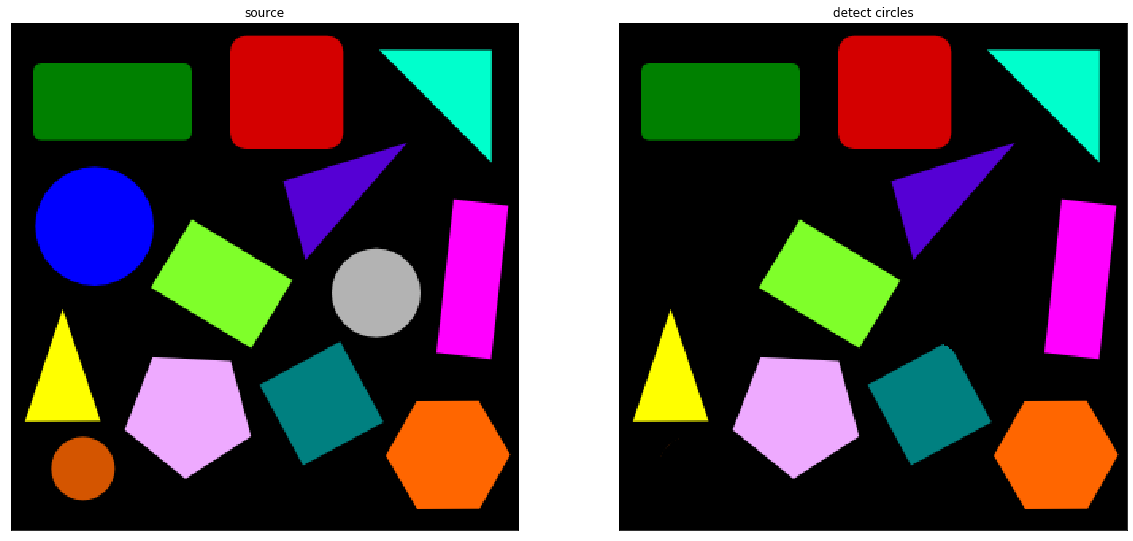

In [6]:
image_list = []

image = cv2.imread(os.path.join('images', '1.png'))
image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'source', 'img'])

out_img = remove_circles(image)

image_list.append([cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB), 'detect circles', 'img'])

plotter(image_list, 1, 2, True, 20, 10, 'q4a')

## Line Detection

**First** I used canny edge detector. **Second** I use the OpenCV HoughLinesP method to detect all the line segments in the canny edge detector output. **Third** I draw white lines on the detected line segments with thickness of 2px.

In [12]:
def detect_lines_hough(image):
    '''
    Returns the image which lines have been detected.
    
    Parameters:
        image (numpy.ndarray): The input image.
        
    Returns:
        out_img (numpy.ndarray): The result image.
    '''
    out_img = image.copy()
        
    edges = cv2.Canny(image, 50, 200)

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 1, minLineLength=0, maxLineGap=0)
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)
        
    out_img = image.copy()
    return out_img

Test of implementation:

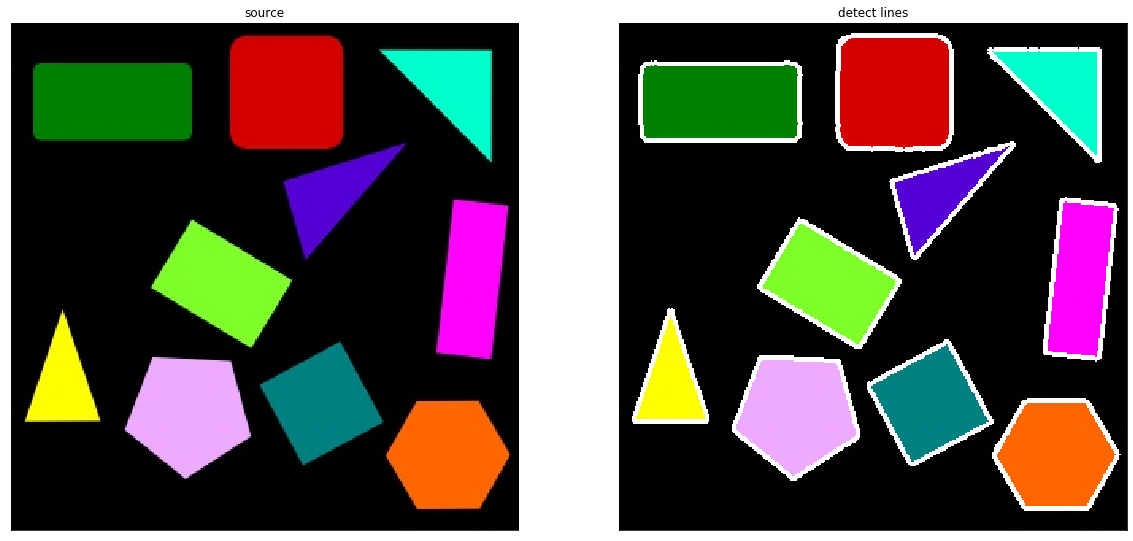

In [13]:
image_list = []

image = cv2.imread(os.path.join('images', '1b.png'))
image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'source', 'img'])

out_img = detect_lines_hough(image)

image_list.append([cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB), 'detect lines', 'img'])

plotter(image_list, 1, 2, True, 20, 10, 'q4b')

# RANSAC

`vote(points, model, deviation)` Calculates number of votes and points which are voting.

`compute_error(points, P1, P2)` Computes the error by calculating a distance matri which is based on the Euclidean distance of points which the suggested model.

`compute_distance(P0, P1, P2)` Returns the Euclidean distance of Point 0 with the model represented by Point 1 and 2.

`calc_pol(points)` Calculates rho and theta based on the points in Cartesian coordinate system.

In [16]:
def vote(points, model, deviation):
    
    P1, P2 = model
    distance_matrix = compute_error(points, P1, P2)
    np.nan_to_num(distance_matrix, copy=False)
    rows, cols = np.where((distance_matrix <= deviation) & (distance_matrix != 0))
    voted_points = list(zip(rows, cols))
    vote = len(voted_points)
    
    return vote, voted_points

def compute_error(points, P1, P2):
    
    distances = np.zeros_like(points, dtype=np.float32)
    
    for i in range(points.shape[0]):
        for j in range(points.shape[1]):
            if points[i, j] == 255:
                P0 = (i, j)
                distances[i, j] = compute_distance(P0, P1, P2)
    return distances

def compute_distance(P0, P1, P2):

    x0, y0 = P0
    x1, y1 = P1
    x2, y2 = P2
    
    dist = np.divide(np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + (x2 * y1) - (y2 * x1)), np.sqrt(np.square(y2 - y1) + np.square(x2 - x1)))
    return dist

def calc_pol(points):
    
    dt = np.dtype('int, int')
    coordinates = np.array(points,dtype=dt)
    
    ### Because x in cartesian plain is equal to the second dimension of array (y)
    ### And y in cartesian plain is equal to the first dimension of array (x)
    coordinates.dtype.names = ['y','x']

    X = coordinates['x']
    Y = coordinates['y']
    
    x_mean = np.mean(X)
    y_mean = np.mean(Y)
    
    numerator = 2 * (np.mean(X * Y) - (x_mean * y_mean))
    denominator = np.mean(np.square(X)) - np.mean(np.square(Y)) - np.square(x_mean) + np.square(y_mean)
    
    theta = 0.5 * np.arctan(np.divide(numerator, denominator))
    rho = x_mean * np.cos(theta) + y_mean * np.sin(theta)
    
    return rho, theta

`ransac(image)` Is the driver function for RANSAC algorithm. Iteration and random sampling in each iteration is done in this function. Returns rho and theta for final model.

In [19]:
import random

def ransac(image):
    '''
    Gets input image and return rho and theta of line detected. 
    
    Parameters:
        image (numpy.ndarray): The input image.
        
    Returns:
        rho (float): The distance from the origin to the line.
        theta (float):  Angle from origin to the line.
    '''

    num_iter = 100
    
    voted = None
    max_vote = -1
    
    deviation = 10
    
    rows, cols = np.where(image > 0)
    coordinates = list(zip(rows, cols))
    
    for i in range(num_iter):
        
        P1 = random.choice(coordinates)
        P2 = random.choice(coordinates)
        
        while P1 == P2:
            P2 = random.choice(coordinates)

        model = (P1, P2)
        
        votes, voting_points = vote(image, model, deviation)
        
        if votes > max_vote:
            max_vote = votes
            voted = voting_points

    rho, theta = calc_pol(voted)

    return rho, theta

Test of implementation:

20.55488454665097 -0.02955917166458268
50 998 -9 -1000


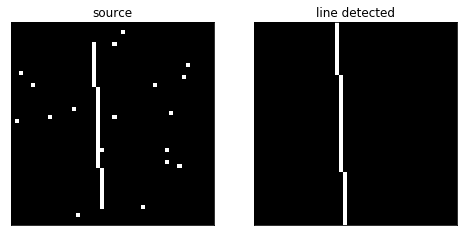

In [20]:
image_list = []
image = cv2.imread(os.path.join('images', '2.bmp'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'source', 'img'])
rho, theta = ransac(image)
print(rho, theta)
x1, y1, x2, y2 = pol_to_car(rho, theta)
print(x1, y1, x2, y2)
image_res = np.zeros_like(image)
cv2.line(image_res, (x1, y1), (x2, y2), (255), 1)
image_list.append([image_res, 'line detected', 'img'])
plotter(image_list, 1, 2, True, 8, 6, 'q5')

# Hough Transform

`compute_rho(x, y, theta)` Computes rho using x, y and theta. Returns the calculates rho.

`vote(hough_transform, rho_range, theta_range)` Computes the most voted model using the Hough Transform and `numpy.argmax()` method. Returns rho and theta of most voted model

In [21]:
def compute_rho(x, y, theta):
    return np.round(x * np.cos(theta) + y * np.sin(theta))

def vote(hough_transform, rho_range, theta_range):
    rho_idx, theta_idx = np.unravel_index(hough_transform.argmax(), hough_transform.shape)
    rho = rho_range[rho_idx]
    theta = theta_range[theta_idx]
    return rho, theta

`hough_transform_line(image)` Is the main driver function for Hough Transform algorithm.

In [22]:
def hough_transform_line(image):
    '''
    Returns rho and theat of line detected and hough transform image.
    
    Parameters:
        image (numpy.ndarray): The input image.
        
    Returns:
        rho (float): Angle from origin to the line.
        theta (float): The distance from the origin to the line.
        hough_transform (numpy.ndarray): Hough transform image.
    '''

    width, height = image.shape
    
    ### Range of theta is -90 to 90 degrees.
    theta_range = np.deg2rad(np.arange(-90.0, 90.0))
    theta_n = theta_range.shape[0]
    
    ### range of rho is 0 to 2 times the diagonal of the image
    rho_max = np.ceil(np.sqrt(np.square(width) + np.square(height))).astype(np.int)
    rho_range = np.linspace(-rho_max, rho_max, rho_max * 2)
    
    hough_transform = np.zeros((2 * rho_max, theta_n))
    
    Y, X = np.where(image > 0)
    
    for n in range(Y.shape[0]):
        for theta_index in range(theta_n):
            
            rho = compute_rho(X[n], Y[n], theta_range[theta_index])
            rho_shifted = int(rho + rho_max)
            hough_transform[rho_shifted, theta_index] += 1
                                
    rho, theta = vote(hough_transform, rho_range, theta_range)
    return rho, theta, hough_transform

Test of implementation:

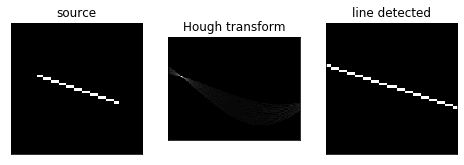

In [23]:
image_list = []
image = cv2.imread(os.path.join('images', '3.bmp'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'source', 'img'])
rho, theta, hough_transform = hough_transform_line(image)
x1, y1, x2, y2 = pol_to_car(rho, theta)
image_list.append([hough_transform, 'Hough transform', 'img'])
image_res = np.zeros_like(image)
cv2.line(image_res, (x1, y1), (x2, y2), (255), 1)
image_list.append([image_res, 'line detected', 'img'])
plotter(image_list, 1, 3, True, 8, 6, 'q6')